In [1]:
import pandas as pd
import numpy as np
import datetime
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [3]:
import statsmodels.tsa.stattools as ts 

# VAR fiting method

In [4]:
# find the max lag by AIC,BIC,FQE,HQIC
def find_lag(data):
    model = VAR(data)
    lags=[]
    for i in [1,2,3,4,5,6,7,8,9,10]:
        try:
            result = model.fit(i)
            lags.append([result.aic,result.bic,result.fpe,result.hqic])
        except np.linalg.LinAlgError as err:
            break
        except ValueError:
            break

    find_lags = pd.DataFrame(lags)
    find_lags.columns = ['aic','bic','fpe','hqic']
    find_lags.index = find_lags.index + 1
    maxlag = find_lags.idxmin().mode().values[0]
    return maxlag

In [5]:
def make_var_model(data, lag, actual_plot = False ):
 
    # make a VAR model
    model = VAR(data)
    results = model.fit(maxlags = lag)
    lag_order = results.k_ar
    fitted_values = results.fittedvalues
    
    # step: number of future weeks
    conf = results.forecast_interval(y= data.values[-lag_order:], steps = 5,alpha=0.8)
    conf_intv = pd.concat([pd.DataFrame(conf[0])[0],
                           pd.DataFrame(conf[1])[0],
                           pd.DataFrame(conf[2])[0]],axis=1)
    conf_intv.columns=['ys','lower','upper']
    return fitted_values,conf_intv,results

In [6]:
# show values on plot
def note(xs,ys,posi,height,colr):  
    for x,y in zip(xs,ys):
        label = "{:.2f}".format(y)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(0,height), # distance from text to points (x,y)
                     ha=posi,va='bottom',color=colr,fontsize=10) 
        # horizontal alignment can be left, right or center
    return

In [7]:
# comare with 
def test_var(dt,lag):
    train = dt[:-5]
    test = dt[-5:]
    
    fitted,conf,results = make_var_model(data = train,lag=lag, actual_plot = False )
    df_res = pd.concat([fitted[['trade_balance']],conf],axis=0)
    df_res['trade_balance'][-5:] = df_res['ys'][-5:]

    rmse = mean_squared_error(test['trade_balance'],df_res['ys'][-5:])
    

    return rmse

# Forecasting

In [8]:
df = pd.read_excel(r'D:\papers\writing_sample\i_s.xlsx','Sheet2')
start = 27
dt = df[['trade_balance', 'gap_(s-i)','ExchangeRate_yuan_dollar']][start:]

In [9]:
max_lag = find_lag(dt)
print(max_lag)
ls_rmse = []
i = 1
while i < max_lag-2:
    rmse = test_var(dt,i)
    ls_rmse.append(rmse)
    i+=1

9


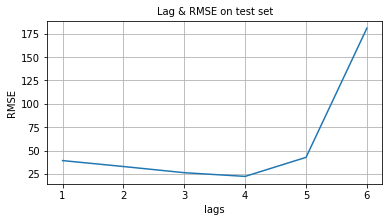

In [10]:
plt.figure(figsize=(6,3) )
plt.title('Lag & RMSE on test set',fontsize=10) 
plt.plot(np.arange(1,max_lag-2),ls_rmse)
plt.ylabel('RMSE')
plt.xlabel('lags')
plt.grid()

In [11]:
def fit_var(dt,lag,start):    
    fitted,conf,results = make_var_model(data = dt,lag=lag, actual_plot = False )
    df_res = pd.concat([fitted[['trade_balance']],conf],axis=0)
    df_res['trade_balance'][-5:] = df_res['ys'][-5:]

    df_res['lower'].iloc[-6] =  df_res['trade_balance'].iloc[-6]
    df_res['upper'].iloc[-6] =  df_res['trade_balance'].iloc[-6]

    df_res['id'] = np.arange(start+lag,96)
    return df_res,results

In [12]:
def plot_var(df,df_res,lag,start):
    plt.figure(figsize=(14,4) )
    clr_n = 'black'
    clr_f='#ffa303'
    clr_t = '#0f3994'

    ls = np.arange(start+lag-2,96)
    xtick = list(df['year-quarter'][start+lag-2:91])+['2021_Q4','2022_Q1','2022_Q2','2022_Q3','2022_Q4']

    plt.title('Forecasting for Trade Balance of U.S.with China (lag = %s)'%lag,fontsize=16) 
    dt_ = dt[-5:]
    df_res_ = df_res[-10:]
    plt.plot(dt_['trade_balance'],label='True',color = clr_t,alpha = 0.7)

    plt.plot(df_res_['id'],df_res_['trade_balance'],label='forecast',color=clr_f)
    plt.plot(df_res['id'], df_res['lower'],ls="--",color=clr_f)
    plt.plot(df_res['id'], df_res['upper'],ls="--",color=clr_f)

    note(dt_.index,dt_['trade_balance'],'left',0,clr_t)
    note(df_res_['id'][:5],df_res_['trade_balance'][:5],'right',-5,clr_n)
    note(df_res_['id'][5:],df_res_['lower'][5:],'right',-5,clr_n)
    note(df_res_['id'][5:],df_res_['upper'][5:],'right',-5,clr_n)

#     plt.title('Details after Zoom Out',fontsize=10) 

    plt.axvline(91, c="tab:gray",ls="--")
    plt.xticks(ls[-11:], xtick[-11:], fontsize = 8, rotation = 90)
    plt.grid(axis='x',alpha=0.5)
    plt.legend(loc='lower right')
    plt.show()
    return 

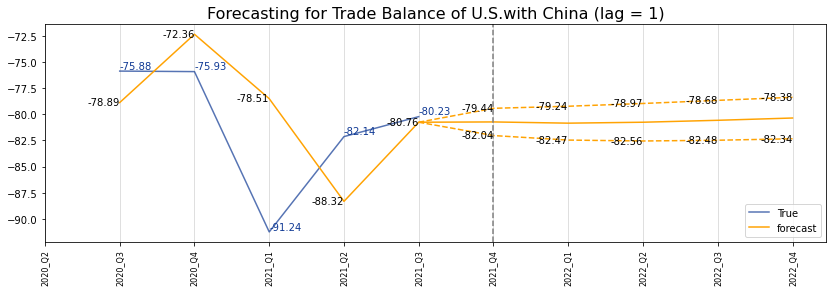

In [13]:
lag = 1
df_res,results = fit_var(dt,lag,start)
plot_var(df,df_res,lag,start)

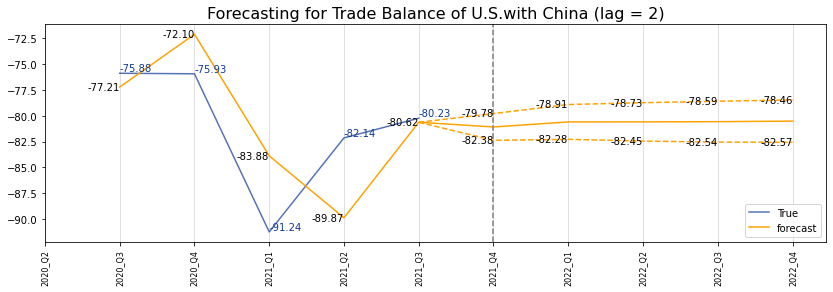

In [14]:
lag = 2
df_res,results = fit_var(dt,lag,start)
plot_var(df,df_res,lag,start)

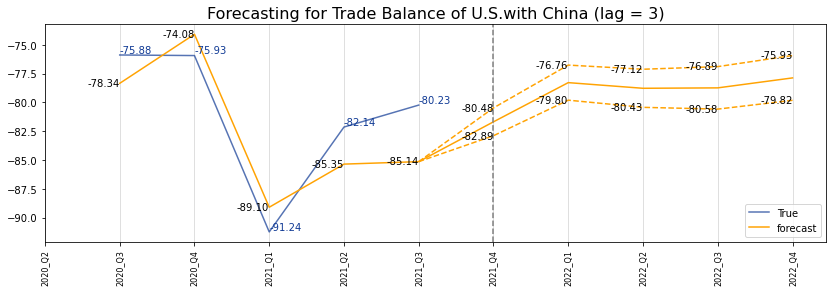

In [15]:
lag = 3
df_res,results = fit_var(dt,lag,start)
plot_var(df,df_res,lag,start)

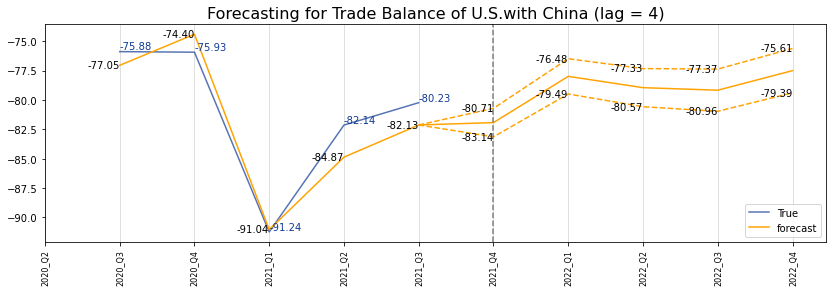

In [16]:
lag = 4
df_res,results = fit_var(dt,lag,start)
plot_var(df,df_res,lag,start)

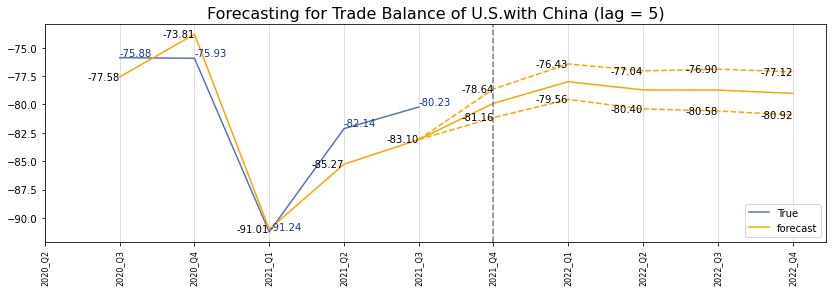

In [17]:
lag = 5
df_res,results = fit_var(dt,lag,start)
plot_var(df,df_res,lag,start)

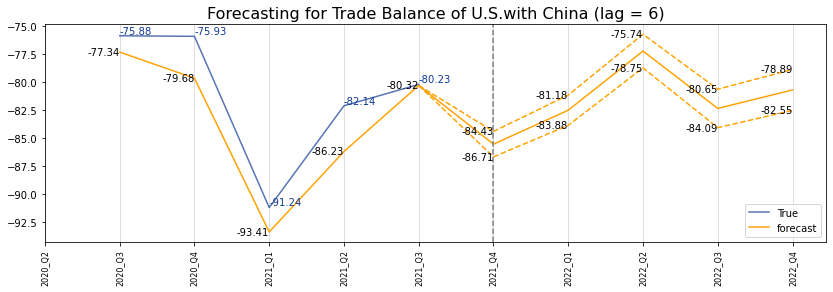

In [18]:
lag = 6
df_res,results = fit_var(dt,lag,start)
plot_var(df,df_res,lag,start)

In [19]:
def plot_var_all(df,df_res,lag,start):
    plt.figure(figsize=(14,8) )
    clr_n = 'black'
    clr_f='#ffa303'
    clr_t = '#0f3994'

    ls = np.arange(start+lag-2,96)
    xtick = list(df['year-quarter'][start+lag-2:91])+['2021_Q4','2022_Q1','2022_Q2','2022_Q3','2022_Q4']

    plt.subplot(211)
    plt.title('Forecasting for Trade Balance of U.S.with China (lag = %s)'%lag,fontsize=16) 
    plt.plot(dt['trade_balance'], label='True',color = clr_t,alpha = 0.7)

    plt.plot(df_res['id'], df_res['trade_balance'],label='forecast',color=clr_f)
    plt.plot(df_res['id'], df_res['lower'],ls="--",color=clr_f)
    plt.plot(df_res['id'], df_res['upper'],ls="--",color=clr_f)


    plt.axvline(91, c="tab:gray",ls="--")
    plt.xticks(ls[::4], xtick[::4], fontsize = 8, rotation = 90)
    plt.legend(loc='best')

    plt.subplot(313)
    plt.subplots_adjust(wspace =0, hspace = 0)
    dt_ = dt[-5:]
    df_res_ = df_res[-10:]
    plt.plot(dt_['trade_balance'],label='True',color = clr_t,alpha = 0.7)

    plt.plot(df_res_['id'],df_res_['trade_balance'],label='forecast',color=clr_f)
    plt.plot(df_res['id'], df_res['lower'],ls="--",color=clr_f)
    plt.plot(df_res['id'], df_res['upper'],ls="--",color=clr_f)

    note(dt_.index,dt_['trade_balance'],'left',0,clr_t)
    note(df_res_['id'][:5],df_res_['trade_balance'][:5],'right',-5,clr_n)
    note(df_res_['id'][5:],df_res_['lower'][5:],'right',-5,clr_n)
    note(df_res_['id'][5:],df_res_['upper'][5:],'right',-5,clr_n)

    plt.title('Details after Zoom Out',fontsize=10) 

    plt.axvline(91, c="tab:gray",ls="--")
    plt.xticks(ls[-11:], xtick[-11:], fontsize = 8, rotation = 90)
    plt.grid(axis='x',alpha=0.5)
    plt.legend(loc='lower right')
    plt.show()
    return 

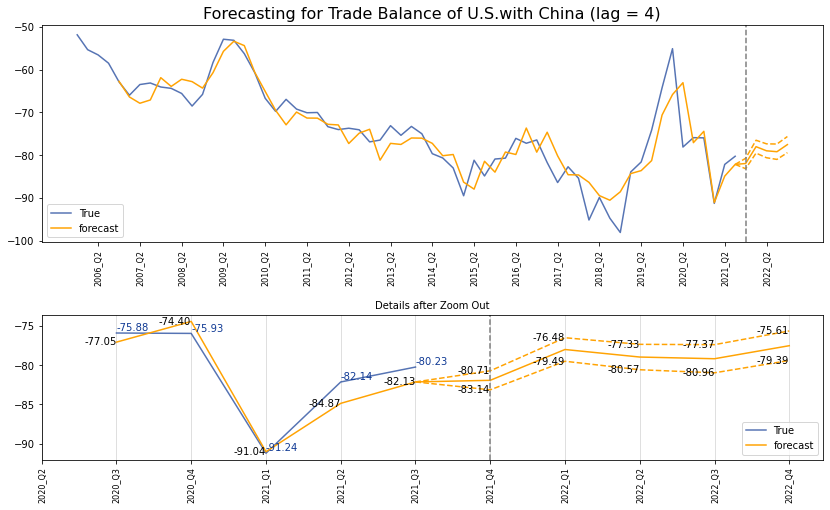

In [20]:
lag = 4
df_res,results = fit_var(dt,lag,start)
plot_var_all(df,df_res,lag,start)